#### 원저자의 cost 함수를 수정함 maximize p(x|z) 대신 minimize MSE 사용: lib.models_varia
#### 원저자의 cost 함수는 lib.models

#####  missing values 로 mask 되어있는 hat_Values만 선택되어 mse 및 map 가 적용됨

In [1]:
import sys
import os
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from absl import app
from absl import flags
sys.path.append("..")
from lib.models_varia_mse_y_only_for_gp import *

# Enable mixed precision for performance
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt

outdir = './results/GPVAE_newver2/'
# DATA = np.load("../../2.ProcessedData/mimic_30s_sample.npy")
checkpoint_prefix = os.path.join(outdir, "ckpt")

data_type = 'hmnist'
testing = False
num_steps = 0 # 'Number of training steps: If non-zero it overwrites num_epochs'
num_epochs = 10000
batch_size = 1500
print_interval = 0
TrRate = 0.8
LatDim = 10


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


### Data load

In [2]:
Data = np.load("D:/Dropbox/AICleansing_ver2/2.ProcessedData/train_mimic_orgscale.npy")
# ValData = np.load("D:/Dropbox/AICleansing_ver2/2.ProcessedData/valid_vitaldb_orgscale.npy")
np.random.shuffle(Data)
data_len = len(Data)
ValData = Data[:data_len//5]
TrData = Data[data_len//5:]
print(TrData.shape, ValData.shape)

(283380, 3000) (70844, 3000)


### Data processing

In [3]:
#Ver2

TrDataFrame = tf.signal.frame(TrData.astype('float32'), 50, 50).numpy()
ValDataFrame = tf.signal.frame(ValData.astype('float32'), 50, 50).numpy()

np.random.shuffle(TrDataFrame)
np.random.shuffle(ValDataFrame)

m_train_miss = np.random.choice([1,0], size=TrDataFrame.shape, p=[0.1,0.9])
m_val_miss = np.random.choice([1,0], size=ValDataFrame.shape, p=[0.1,0.9])

Tr_X = TrDataFrame.copy()
Tr_Y = (TrDataFrame - 20.0) / (220.0 - 20.0)
# 평균 80, 표준 편차 25인 정규 분포에서 값을 뽑아서 채울 배열 생성
random_values = np.random.normal(loc=80, scale=25, size=TrDataFrame.shape)
# m_train_miss가 1인 위치에 뽑은 값을 할당
Tr_X[m_train_miss == 1] = random_values[m_train_miss == 1]
Tr_X = (Tr_X - 20.0) / (220.0 - 20.0)

m_train_miss[:,-10:,:] = 1
Tr_X[:,-10:,:] = Tr_X[:,-10:,:] + np.random.normal(loc=0.0, scale=0.05, size=Tr_X[:,-10:,:].shape)

Tr_X = np.clip(Tr_X, 0.0, 1.0)

Val_X = ValDataFrame.copy()
Val_Y = (ValDataFrame - 20.0) / (220.0 - 20.0)
# 평균 80, 표준 편차 25인 정규 분포에서 값을 뽑아서 채울 배열 생성
random_values = np.random.normal(loc=80, scale=25, size=ValDataFrame.shape)
# m_train_miss가 1인 위치에 뽑은 값을 할당
Val_X[m_val_miss == 1] = random_values[m_val_miss == 1]
Val_X = (Val_X - 20.0) / (220.0 - 20.0)

m_val_miss[:,-10:,:] = 1
Val_X[:,-10:,:] = Val_X[:,-10:,:] + np.random.normal(loc=0.0, scale=0.05, size=Val_X[:,-10:,:].shape)

Val_X = np.clip(Val_X, 0.0, 1.0)

data_dim = TrDataFrame.shape[-1]
time_length = TrDataFrame.shape[1]
tr_sig_nb = len(TrDataFrame)

del random_values
del TrDataFrame
del ValDataFrame

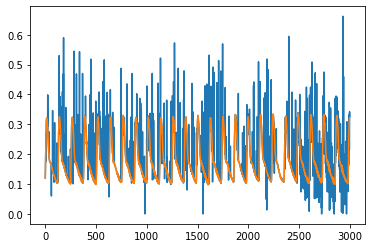

In [4]:
plt.plot(Tr_X[0].ravel())
plt.plot(Tr_Y[0].ravel())

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf_x_train_miss = (
    tf.data.Dataset.from_tensor_slices((Tr_X, Tr_Y, m_train_miss))
    .shuffle(tr_sig_nb)
    .batch(batch_size)
    .repeat()
    .prefetch(AUTOTUNE)  # Add prefetching.
)


### Model build

In [13]:
encoder = BandedJointEncoderGRU
decoder = GaussianDecoder


model = GP_VAE(latent_dim=LatDim, 
               data_dim=data_dim, 
               time_length=time_length,
               encoder_sizes=[100, 80, 60], encoder=encoder,
               decoder_sizes=[60,80,100], decoder=decoder,
               kernel='cauchy', 
               sigma=1.,
               length_scale=0.1, 
               kernel_scales = 1,
               #image_preprocessor=image_preprocessor, 
               window_size=10,
               beta=0.1, M=1, K=1, 
               #data_type=data_type     
              )

In [14]:
_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

# For global step
global_step = tf.Variable(0, trainable=False)

gradient_clip = 1e4
learning_rate = 0.0005

# Initialize optimizer and learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Checkpoints
checkpoint = {
    "optimizer": optimizer,
    "encoder": model.encoder.net,
    "decoder": model.decoder.net,
    "global_step": global_step
}

if model.preprocessor is not None:
    print("Preprocessor: ", model.preprocessor.net.summary())
    checkpoint["preprocessor"] = model.preprocessor.net

saver = tf.train.Checkpoint(**checkpoint)

# TensorBoard
summary_writer = tf.summary.create_file_writer(outdir+'log/', flush_millis=10000)

# Compute steps and intervals
if num_steps == 0:
    num_steps = num_epochs * tr_sig_nb // batch_size
else:
    num_steps = num_steps

if print_interval == 0:
    print_interval = num_steps // num_epochs

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (1, 60, 100)              45600     
_________________________________________________________________
dense_6 (Dense)              (1, 60, 80)               8080      
_________________________________________________________________
dense_7 (Dense)              (1, 60, 60)               4860      
_________________________________________________________________
dense_8 (Dense)              (1, 60, 30)               1830      
Total params: 60,370
Trainable params: 60,370
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (1, 60, 60)               660       
_____________

### Load weights

In [15]:
# model.encoder.net.load_weights(outdir+'encoder2.hdf5')
# model.decoder.net.load_weights(outdir+'decoder2.hdf5')

### Training 

In [16]:

# # Function for a single training step
# @tf.function
# def train_step(x_seq, y_seq, m_seq, model, optimizer):
#     with tf.GradientTape() as tape:
#         loss = model.compute_loss(x_seq, y_seq, m_mask=m_seq)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     # Gradient Clipping
#     clipped_grads = [tf.clip_by_value(grad, -gradient_clip, gradient_clip) for grad in gradients]
#     optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))
#     return loss

# # To store losses
# losses_train = []
# losses_val = []

# # For best model saving
# val_loss_check = np.inf

# t0 = time.time()

# # For TensorBoard visualization
# summary_writer = tf.summary.create_file_writer("/path/to/log_dir")

# with summary_writer.as_default():
#     for i, (x_seq, y_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
#         loss = train_step(x_seq, y_seq, m_seq, model, optimizer)
#         losses_train.append(loss.numpy())

#         if i % print_interval == 0:
#             print("================================================")
#             print("Learning rate: {} | Global gradient norm: {:.2f}".format(
#                 optimizer._decayed_lr('float32'), 
#                 tf.linalg.global_norm(model.trainable_variables))
#             )
#             print("Step {}) Time = {:2f}".format(i, time.time() - t0))
#             loss, mse, kl = model.compute_loss(x_seq, y_seq, m_mask=m_seq, return_parts=True)
#             print("Train loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(loss, mse, kl))
            
#             tf.summary.scalar("loss_train", loss, step=i)
#             tf.summary.scalar("kl_train", kl, step=i)
#             tf.summary.scalar("mse_train", mse, step=i)

#             # Validation
#             random_indices = np.random.choice(len(Val_X), size=batch_size, replace=False)
#             random_batch_X = Val_X[random_indices]
#             random_batch_Y = Val_Y[random_indices]
#             random_batch_m = m_val_miss[random_indices]
#             val_loss, val_mse, val_kl = model.compute_loss(random_batch_X, random_batch_Y, m_mask=random_batch_m, return_parts=True)
#             losses_val.append(val_loss.numpy())
            
#             print("Validation loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(val_loss, val_mse, val_kl))

#             tf.summary.scalar("loss_val", val_loss, step=i)
#             tf.summary.scalar("kl_val", val_kl, step=i)
#             tf.summary.scalar("mse_val", val_mse, step=i)

#             if val_loss_check > val_loss:
#                 val_loss_check = val_loss
#                 model.encoder.net.save_weights(outdir+'encoder_gpvae_1.hdf5')
#                 model.decoder.net.save_weights(outdir+'decoder_gpvae_1.hdf5')
#                 # Stop training if val_mse goes below 0.00043
#                 if val_mse < 0.00043:
#                     print("Stopping training as val_mse reached below 0.00043.")
#                     break

#             t0 = time.time()


In [17]:

# # Function for a single training step
# @tf.function
# def train_step(x_seq, y_seq, m_seq, model, optimizer):
#     with tf.GradientTape() as tape:
#         loss = model.compute_loss(x_seq, y_seq, m_mask=m_seq)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     # Gradient Clipping
#     clipped_grads = [tf.clip_by_value(grad, -gradient_clip, gradient_clip) for grad in gradients]
#     optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))
#     return loss

# # To store losses
# losses_train = []
# losses_val = []

# # For best model saving
# val_loss_check = 0.00123

# t0 = time.time()

# # For TensorBoard visualization
# summary_writer = tf.summary.create_file_writer("/path/to/log_dir")

# with summary_writer.as_default():
#     for i, (x_seq, y_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
#         loss = train_step(x_seq, y_seq, m_seq, model, optimizer)
#         losses_train.append(loss.numpy())

#         if i % print_interval == 0:
#             print("================================================")
#             print("Learning rate: {} | Global gradient norm: {:.2f}".format(
#                 optimizer._decayed_lr('float32'), 
#                 tf.linalg.global_norm(model.trainable_variables))
#             )
#             print("Step {}) Time = {:2f}".format(i, time.time() - t0))
#             loss, mse, kl = model.compute_loss(x_seq, y_seq, m_mask=m_seq, return_parts=True)
#             print("Train loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(loss, mse, kl))
            
#             tf.summary.scalar("loss_train", loss, step=i)
#             tf.summary.scalar("kl_train", kl, step=i)
#             tf.summary.scalar("mse_train", mse, step=i)

#             # Validation
#             random_indices = np.random.choice(len(Val_X), size=batch_size, replace=False)
#             random_batch_X = Val_X[random_indices]
#             random_batch_Y = Val_Y[random_indices]
#             random_batch_m = m_val_miss[random_indices]
#             val_loss, val_mse, val_kl = model.compute_loss(random_batch_X, random_batch_Y, m_mask=random_batch_m, return_parts=True)
#             losses_val.append(val_loss.numpy())
            
#             print("Validation loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(val_loss, val_mse, val_kl))

#             tf.summary.scalar("loss_val", val_loss, step=i)
#             tf.summary.scalar("kl_val", val_kl, step=i)
#             tf.summary.scalar("mse_val", val_mse, step=i)

#             if val_loss_check > val_loss:
#                 val_loss_check = val_loss
#                 model.encoder.net.save_weights(outdir+'encoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
#                 model.decoder.net.save_weights(outdir+'decoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
# #                 # Stop training if val_mse goes below 0.00043
# #                 if val_mse < 0.00043:
# #                     print("Stopping training as val_mse reached below 0.00043.")
# #                     break

#             t0 = time.time()


In [18]:
model.encoder.net.load_weights(outdir+'encoder_gpvae_val0.00092348515_valmse0.00028393653.hdf5')
model.decoder.net.load_weights(outdir+'decoder_gpvae_val0.00092348515_valmse0.00028393653.hdf5')

In [ ]:

# Function for a single training step
@tf.function
def train_step(x_seq, y_seq, m_seq, model, optimizer):
    with tf.GradientTape() as tape:
        loss = model.compute_loss(x_seq, y_seq, m_mask=m_seq)
    gradients = tape.gradient(loss, model.trainable_variables)
    # Gradient Clipping
    clipped_grads = [tf.clip_by_value(grad, -gradient_clip, gradient_clip) for grad in gradients]
    optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))
    return loss

# To store losses
losses_train = []
losses_val = []

# For best model saving
val_loss_check = 0.00092348515

t0 = time.time()

# For TensorBoard visualization
summary_writer = tf.summary.create_file_writer("/path/to/log_dir")

with summary_writer.as_default():
    for i, (x_seq, y_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
        loss = train_step(x_seq, y_seq, m_seq, model, optimizer)
        losses_train.append(loss.numpy())

        if i % print_interval == 0:
            print("================================================")
            print("Learning rate: {} | Global gradient norm: {:.2f}".format(
                optimizer._decayed_lr('float32'), 
                tf.linalg.global_norm(model.trainable_variables))
            )
            print("Step {}) Time = {:2f}".format(i, time.time() - t0))
            loss, mse, kl = model.compute_loss(x_seq, y_seq, m_mask=m_seq, return_parts=True)
            print("Train loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(loss, mse, kl))
            
            tf.summary.scalar("loss_train", loss, step=i)
            tf.summary.scalar("kl_train", kl, step=i)
            tf.summary.scalar("mse_train", mse, step=i)

            # Validation
            random_indices = np.random.choice(len(Val_X), size=batch_size, replace=False)
            random_batch_X = Val_X[random_indices]
            random_batch_Y = Val_Y[random_indices]
            random_batch_m = m_val_miss[random_indices]
            val_loss, val_mse, val_kl = model.compute_loss(random_batch_X, random_batch_Y, m_mask=random_batch_m, return_parts=True)
            losses_val.append(val_loss.numpy())
            
            print("Validation loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(val_loss, val_mse, val_kl))

            tf.summary.scalar("loss_val", val_loss, step=i)
            tf.summary.scalar("kl_val", val_kl, step=i)
            tf.summary.scalar("mse_val", val_mse, step=i)

            if val_loss_check > val_loss:
                val_loss_check = val_loss
                model.encoder.net.save_weights(outdir+'encoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
                model.decoder.net.save_weights(outdir+'decoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
#                 # Stop training if val_mse goes below 0.00043
#                 if val_mse < 0.00043:
#                     print("Stopping training as val_mse reached below 0.00043.")
#                     break

            t0 = time.time()


Learning rate: 0.0004999947268515825 | Global gradient norm: 141.60
Step 0) Time = 81.041226
Train loss = 0.03281 | mse = 0.03211 | KL = 0.00070
Validation loss = 0.03191 | mse = 0.03121 | KL = 0.00070
Learning rate: 0.0004990053130313754 | Global gradient norm: 141.58
Step 188) Time = 181.478992
Train loss = 0.00095 | mse = 0.00030 | KL = 0.00065
Validation loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Learning rate: 0.0004980178782716393 | Global gradient norm: 141.58
Step 376) Time = 209.651948
Train loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Validation loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Learning rate: 0.0004970324225723743 | Global gradient norm: 141.58
Step 564) Time = 232.882617
Train loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Validation loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Learning rate: 0.0004960488877259195 | Global gradient norm: 141.59
Step 752) Time = 236.855197
Train loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Validation loss = 0.00094 | mse = 0

Train loss = 0.00101 | mse = 0.00037 | KL = 0.00065
Validation loss = 0.00102 | mse = 0.00037 | KL = 0.00065
Learning rate: 0.0004683574952650815 | Global gradient norm: 141.74
Step 6204) Time = 177.180178
Train loss = 0.00096 | mse = 0.00031 | KL = 0.00065
Validation loss = 0.00096 | mse = 0.00031 | KL = 0.00065
Learning rate: 0.0004674307128880173 | Global gradient norm: 141.75
Step 6392) Time = 172.775655
Train loss = 0.00095 | mse = 0.00031 | KL = 0.00065
Validation loss = 0.00097 | mse = 0.00032 | KL = 0.00065
Learning rate: 0.00046650576405227184 | Global gradient norm: 141.75
Step 6580) Time = 179.376045
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Learning rate: 0.0004655826196540147 | Global gradient norm: 141.76
Step 6768) Time = 177.246445
Train loss = 0.00112 | mse = 0.00047 | KL = 0.00065
Validation loss = 0.00112 | mse = 0.00047 | KL = 0.00065
Learning rate: 0.00046466130879707634 | Global gradient norm: 141.

Validation loss = 0.00093 | mse = 0.00029 | KL = 0.00065
Learning rate: 0.00043959199683740735 | Global gradient norm: 142.03
Step 12220) Time = 177.502597
Train loss = 0.00097 | mse = 0.00032 | KL = 0.00065
Validation loss = 0.00096 | mse = 0.00031 | KL = 0.00065
Learning rate: 0.0004387220833450556 | Global gradient norm: 142.04
Step 12408) Time = 175.468910
Train loss = 0.00098 | mse = 0.00033 | KL = 0.00065
Validation loss = 0.00097 | mse = 0.00032 | KL = 0.00065
Learning rate: 0.00043785397429019213 | Global gradient norm: 142.05
Step 12596) Time = 174.927480
Train loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Learning rate: 0.00043698755325749516 | Global gradient norm: 142.06
Step 12784) Time = 179.249115
Train loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0004361228202469647 | Global gradient norm: 142.07
Step 12972) Time = 175.968244
Train loss = 0

Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0004125931882299483 | Global gradient norm: 142.42
Step 18236) Time = 178.285222
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.00041177673847414553 | Global gradient norm: 142.44
Step 18424) Time = 180.307867
Train loss = 0.00097 | mse = 0.00032 | KL = 0.00065
Validation loss = 0.00096 | mse = 0.00031 | KL = 0.00065
Learning rate: 0.0004109619476366788 | Global gradient norm: 142.46
Step 18612) Time = 174.115951
Train loss = 0.00094 | mse = 0.00030 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Learning rate: 0.0004101486993022263 | Global gradient norm: 142.47
Step 18800) Time = 177.434254
Train loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Learning rate: 0.00040933708078227937 | Global gradient norm: 142.48
Step 18988) Time = 176.120812
Train loss = 0.

Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0003872525994665921 | Global gradient norm: 142.86
Step 24252) Time = 179.098531
Train loss = 0.00093 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0003864862665068358 | Global gradient norm: 142.87
Step 24440) Time = 194.715463
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0003857215342577547 | Global gradient norm: 142.88
Step 24628) Time = 191.363174
Train loss = 0.00096 | mse = 0.00031 | KL = 0.00065
Validation loss = 0.00095 | mse = 0.00031 | KL = 0.00065
Learning rate: 0.0003849582572001964 | Global gradient norm: 142.90
Step 24816) Time = 185.415411
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Learning rate: 0.0003841964644379914 | Global gradient norm: 142.91
Step 25004) Time = 189.682755
Train loss = 0.00

Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.00036346836714074016 | Global gradient norm: 143.28
Step 30268) Time = 185.768036
Train loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Validation loss = 0.00094 | mse = 0.00030 | KL = 0.00065
Learning rate: 0.0003627491241786629 | Global gradient norm: 143.29
Step 30456) Time = 188.672911
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Learning rate: 0.00036203133640810847 | Global gradient norm: 143.31
Step 30644) Time = 184.856829
Train loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.00036131494562141597 | Global gradient norm: 143.32
Step 30832) Time = 184.926182
Train loss = 0.00094 | mse = 0.00030 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.0003605999518185854 | Global gradient norm: 143.34
Step 31020) Time = 191.850457
Train loss = 0

Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0003411449433770031 | Global gradient norm: 143.69
Step 36284) Time = 196.000023
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.0003404698509257287 | Global gradient norm: 143.71
Step 36472) Time = 199.612163
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00065
Learning rate: 0.0003397961554583162 | Global gradient norm: 143.72
Step 36660) Time = 193.955825
Train loss = 0.00093 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.00033912374055944383 | Global gradient norm: 143.73
Step 36848) Time = 191.741977
Train loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00095 | mse = 0.00030 | KL = 0.00065
Learning rate: 0.0003384526935406029 | Global gradient norm: 143.75
Step 37036) Time = 189.707125
Train loss = 0.0

Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0003201925428584218 | Global gradient norm: 144.10
Step 42300) Time = 179.031284
Train loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0003195589524693787 | Global gradient norm: 144.11
Step 42488) Time = 180.469158
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00065
Validation loss = 0.00093 | mse = 0.00028 | KL = 0.00065
Learning rate: 0.00031892655533738434 | Global gradient norm: 144.13
Step 42676) Time = 178.746082
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.000318295496981591 | Global gradient norm: 144.14
Step 42864) Time = 178.930641
Train loss = 0.00094 | mse = 0.00029 | KL = 0.00065
Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.00031766563188284636 | Global gradient norm: 144.15
Step 43052) Time = 182.879062
Train loss = 0.0

Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0003005270264111459 | Global gradient norm: 144.50
Step 48316) Time = 178.936429
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00029993231873959303 | Global gradient norm: 144.52
Step 48504) Time = 175.000393
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00029933880432508886 | Global gradient norm: 144.53
Step 48692) Time = 179.482242
Train loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Validation loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Learning rate: 0.00029874645406380296 | Global gradient norm: 144.54
Step 48880) Time = 175.764259
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002981552970595658 | Global gradient norm: 144.55
Step 49068) Time = 179.405879
Train loss = 0

Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.00028206928982399404 | Global gradient norm: 144.89
Step 54332) Time = 178.722493
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00028151110745966434 | Global gradient norm: 144.90
Step 54520) Time = 178.408231
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00028095406014472246 | Global gradient norm: 144.91
Step 54708) Time = 178.539004
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00092 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002803980896715075 | Global gradient norm: 144.92
Step 54896) Time = 181.493528
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.00027984322514384985 | Global gradient norm: 144.93
Step 55084) Time = 179.901758
Train loss = 

Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.0002647451765369624 | Global gradient norm: 145.24
Step 60348) Time = 190.461324
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00093 | mse = 0.00029 | KL = 0.00064
Learning rate: 0.0002642213075887412 | Global gradient norm: 145.25
Step 60536) Time = 191.052522
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00026 | KL = 0.00064
Learning rate: 0.00026369845727458596 | Global gradient norm: 145.26
Step 60724) Time = 184.688757
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002631766255944967 | Global gradient norm: 145.27
Step 60912) Time = 181.403167
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002626558707561344 | Global gradient norm: 145.29
Step 61100) Time = 176.922974
Train loss = 0.0

Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002484850992914289 | Global gradient norm: 145.58
Step 66364) Time = 194.950362
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002479933900758624 | Global gradient norm: 145.60
Step 66552) Time = 197.704449
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Learning rate: 0.0002475026703905314 | Global gradient norm: 145.61
Step 66740) Time = 190.357173
Train loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Validation loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Learning rate: 0.00024701288202777505 | Global gradient norm: 145.62
Step 66928) Time = 190.458844
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.0002465240831952542 | Global gradient norm: 145.63
Step 67116) Time = 193.595526
Train loss = 0.0

Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00023322369088418782 | Global gradient norm: 145.92
Step 72380) Time = 189.066017
Train loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Validation loss = 0.00092 | mse = 0.00028 | KL = 0.00064
Learning rate: 0.00023276216234080493 | Global gradient norm: 145.92
Step 72568) Time = 198.252094
Train loss = 0.00095 | mse = 0.00031 | KL = 0.00064
Validation loss = 0.00094 | mse = 0.00030 | KL = 0.00064
Learning rate: 0.0002323015796719119 | Global gradient norm: 145.94
Step 72756) Time = 199.889243
Train loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Validation loss = 0.00090 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00023184188466984779 | Global gradient norm: 145.95
Step 72944) Time = 197.893739
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00023138310643844306 | Global gradient norm: 145.96
Step 73132) Time = 195.080241
Train loss = 

Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00021889957133680582 | Global gradient norm: 146.25
Step 78396) Time = 182.059453
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00021846643358003348 | Global gradient norm: 146.25
Step 78584) Time = 184.853490
Train loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Validation loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Learning rate: 0.00021803411073051393 | Global gradient norm: 146.27
Step 78772) Time = 202.430205
Train loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00090 | mse = 0.00026 | KL = 0.00064
Learning rate: 0.00021760266099590808 | Global gradient norm: 146.28
Step 78960) Time = 194.680308
Train loss = 0.00090 | mse = 0.00027 | KL = 0.00064
Validation loss = 0.00091 | mse = 0.00027 | KL = 0.00064
Learning rate: 0.00021717208437621593 | Global gradient norm: 146.28
Step 79148) Time = 199.568950
Train loss =

In [21]:
# model.encoder.net.save_weights(outdir+'encoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')
# model.decoder.net.save_weights(outdir+'decoder_gpvae_val'+str(val_loss.numpy())+'_valmse'+str(val_mse.numpy())+'.hdf5')

In [9]:
# @tf.function
# def train_step(x_seq, y_seq, m_seq, model, optimizer):
#     with tf.GradientTape() as tape:
#         loss = model.compute_loss(x_seq, y_seq, m_mask=m_seq)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return loss

# gradient_clip = 1e4
# debug= True

# losses_train = []
# losses_val = []

# val_loss_check = np.inf

# t0 = time.time()
# with summary_writer.as_default(), tf.summary.record_if(lambda: True):
#     for i, (x_seq, y_seq, m_seq) in enumerate(tf_x_train_miss.take(num_steps)):
#         loss = train_step(x_seq, y_seq, m_seq, model, optimizer)
#         losses_train.append(loss.numpy())
            
#         # Print intermediate results
#         if i % print_interval == 0:
#             print("================================================")
#             print("Learning rate: {} | Global gradient norm: {:.2f}".format(optimizer._lr, tf.linalg.global_norm(model.trainable_variables)))
#             print("Step {}) Time = {:2f}".format(i, time.time() - t0))
#             loss, mse, kl = model.compute_loss(x_seq, y_seq, m_mask=m_seq, return_parts=True)
#             print("Train loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(loss, mse, kl))
            
#             tf.summary.scalar("loss_train", loss, step=i)
#             tf.summary.scalar("kl_train", kl, step=i)
#             tf.summary.scalar("mse_train", mse, step=i)

#             # Validation loss
#             random_indices = np.random.choice(len(Val_X), size=batch_size, replace=False)
#             random_batch_X = Val_X[random_indices]
#             random_batch_Y = Val_Y[random_indices]
#             random_batch_m = m_val_miss[random_indices]
#             val_loss, val_mse, val_kl = model.compute_loss(random_batch_X, random_batch_Y, m_mask=random_batch_m, return_parts=True)
#             losses_val.append(val_loss.numpy())
            
            
# #             for x_val_batch, y_val_batch, m_val_batch in tf_x_val_miss.take(1): 
# #                 val_loss, val_mse, val_kl = model.compute_loss(x_val_batch, y_val_batch, m_mask=m_val_batch, return_parts=True)
# #                 losses_val.append(val_loss.numpy())

#             print("Validation loss = {:.5f} | mse = {:.5f} | KL = {:.5f}".format(val_loss, val_mse, val_kl))

#             tf.summary.scalar("loss_val", val_loss, step=i)
#             tf.summary.scalar("kl_val", val_kl, step=i)
#             tf.summary.scalar("mse_val", val_mse, step=i)

#             if val_loss_check > val_loss:
#                 val_loss_check = val_loss
#                 model.encoder.net.save_weights(outdir+'encoder_gpvae_1.hdf5')
#                 model.decoder.net.save_weights(outdir+'decoder_gpvae_1.hdf5')


#             # Update learning rate (used only for physionet with decay=0.5)
#             if i > 0 and i % (10*print_interval) == 0:
#                 optimizer._lr = max(0.99 * optimizer._lr, 0.1 * learning_rate)
                
#             t0 = time.time()


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000001CDAC2A4550>
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\py38_gpu\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 534, in __del__
    gen_dataset_ops.delete_iterator(
  File "C:\Users\USER\anaconda3\envs\py38_gpu\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1262, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


KeyboardInterrupt: 